In [8]:
import jupyter_fix

jupyter_fix.fix_jupyter_path()


In [9]:
import src.utility.symbols_loader as sl
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import einops
import os
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm
from pathlib import Path
import datetime
from src.architectures.course_autoencoder import Autoencoder, Encoder, Decoder


In [10]:
### Configure PyTorch

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # should improve speed if input size don't change

In [12]:
### Set constants
LATENT_WIDTH = 32
path = "data/models/"

In [13]:

emnist_Autoencoder = Autoencoder(Encoder(LATENT_WIDTH), Decoder(LATENT_WIDTH))
emnist_Autoencoder.load_state_dict(torch.load(path + '1672367363_emnist_course_autoencoder_32.pth'))
emnist_Autoencoder.to(device)

Autoencoder(
  (encoder): Encoder(
    (model): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, af

In [14]:
from src.architectures.letters_dataset import LettersDataset

mnist_dataset = LettersDataset(sl.load_emnist_pages(5, trial='trial_4'))
print(sl.load_emnist_pages(5, trial='trial_4').shape)
emnist_val_loader = DataLoader(
    mnist_dataset,
    batch_size=1,
    num_workers=4,
    shuffle=False,
    pin_memory=True,
)

(11688, 32, 32)


In [15]:
emnist_preds = []

with torch.no_grad() as nograd:
    for batch in tqdm(emnist_val_loader):
        images = batch.to(device)
        predictions, _ = emnist_Autoencoder(images)

        emnist_preds.append(predictions.cpu())


100%|██████████| 11688/11688 [00:33<00:00, 346.61it/s]


In [16]:
emnist_preds_numpy = np.zeros((len(emnist_preds), 32, 32))

iterator = 0
for tensor in emnist_preds:
    for block in range(tensor.shape[0]):
        emnist_preds_numpy[iterator] = tensor[block].numpy().copy()
        iterator += 1

emnist_preds_numpy.shape
path = "data/encoded_data/"
np.savez_compressed(path + "emnist_decoded.npz", emnist_preds_numpy)



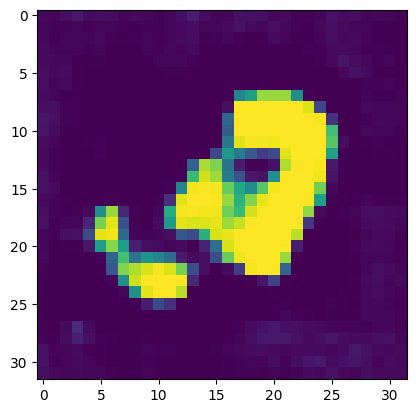

In [17]:
plt.imshow(emnist_preds_numpy[65])